In [1]:
from loadmodules import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture
from matplotlib import ticker

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
parent_dir = './level4/'
simulation_1 = 'Au06_cfea_scbase'
simulation_2 = 'Au06_cfea_compressive'

sims = [simulation_1, simulation_2]
snapshot = 127

In [3]:
def calculate_cfr_and_age_distribution(sim, nbins, min_range, max_range, snapshot=127, cut_feh=None):
    sf = load_subfind(snapshot, dir=sim, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=sim, subfind=sf, hdf5=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    galrad = sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
    elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
    #from Asplund et al. (2009) Table 5
    SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
    for iel,val in enumerate(element):
        s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
        s.data[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    starparts = (s.data['age']>0.) * (s.r()<galrad) * (s.data['subhalo']==0)

    Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)

    mask_clusters_initial = (s.data['incl'][starparts] > 0 )
    
    jz = Lz[starparts]
    ii = np.argsort(orbital_energy[starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1

    # Build feature array: [ε, Energy]
    X = np.vstack((eps,orbital_energy[starparts],
                    np.log10(np.abs(s.data['pos'][:,0][starparts])))).T

    # Fit GMM
    gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[starparts]), -2.0],
                                                    [0.9,np.median(orbital_energy[starparts]), -5.0]],
                                                    covariance_type='full', random_state=42)
    gmm.fit(X)

    # Predict cluster memberships
    decomp_labels = gmm.predict(X)
    median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
    sph_label = np.argmin(np.array(median_eps))
    disc_label = np.argmax(np.array(median_eps))

    # Force assign disc_label to clusters with high circularity parameter
    mask = (decomp_labels == sph_label) & (eps > 0.7)# & (s.r()[starparts] < np.percentile(s.r()[starparts][decomp_labels == disc_label], 0.5))
    decomp_labels[mask] = disc_label

    # Force assign sph_label to clusters with high z-coordinate (10kpc)
    mask = (decomp_labels == disc_label) & (np.abs(s.data['pos'][:,0][starparts])*1e3 > 5.)
    decomp_labels[mask] = sph_label

    # plt.hist(eps, bins=20, range=[-2, 2],histtype='step')
    # plt.hist(eps[decomp_labels==sph_label], bins=20, range=[-2, 2], histtype='step', label='Spheroid')
    # plt.hist(eps[decomp_labels!=sph_label], bins=20, range=[-2, 2], histtype='step', label='Disc')
    # plt.legend()
    # plt.xlabel('Circularity ε')
    # plt.show()
    
    labels_i = np.repeat(decomp_labels, s.data['incl'][starparts])
    feh_scs_i = np.repeat(s.data['Fe/H'][starparts], s.data['incl'][starparts]) - 0.5

    mask_gc = (labels_i == sph_label)
    cluster_masses = 1e10*s.data['mclt'][starparts][mask_clusters_initial].flatten()
    init_cluster_masses = 1e10*s.data['imcl'][starparts][mask_clusters_initial].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    clusters_age = np.repeat(s.cosmology_get_lookback_time_from_a(s.data['age'][starparts], is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True),
                             s.data['incl'][starparts])

    sfr, _ = np.histogram(s.cosmology_get_lookback_time_from_a(s.data['age'][starparts], is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True),\
                            bins=nbins, range=[min_range, max_range], weights=1e10 * s.data['gima'][starparts] / ((max_range - min_range) / nbins) / 1e9)
    cfr_all, _ = np.histogram(clusters_age, bins=nbins, range=[min_range,max_range], weights=init_cluster_masses/((max_range-min_range)/nbins) /1e9)
    if cut_feh is not None:
        cfr_gc, _ = np.histogram(clusters_age[mask_gc * (init_cluster_masses > 1e5)], bins=nbins, range=[min_range,max_range],
                             weights=init_cluster_masses[mask_gc * (init_cluster_masses > 1e5)]/((max_range-min_range)/nbins) /1e9)
        cfr_gc_cut, _ = np.histogram(clusters_age[mask_gc * (init_cluster_masses > 1e5) * (feh_scs_i < cut_feh)], bins=nbins, range=[min_range,max_range],
                                 weights=init_cluster_masses[mask_gc * (init_cluster_masses > 1e5) * (feh_scs_i < cut_feh)]/((max_range-min_range)/nbins) /1e9)
    else:
        cfr_gc, _ = np.histogram(clusters_age[mask_gc * (init_cluster_masses > 1e5)], bins=nbins, range=[min_range,max_range],
                             weights=init_cluster_masses[mask_gc * (init_cluster_masses > 1e5)]/((max_range-min_range)/nbins) /1e9)
    # age_all, _ = np.histogram(clusters_age[(cluster_masses>0.)], bins=nbins, range=[min_range, max_range], density=True)
    # age_gc, _ = np.histogram(clusters_age[mask_gc * (cluster_masses>0.) * (init_cluster_masses > 1e5)], bins=nbins, range=[min_range, max_range], density=True)
    
    age_all = np.array([sp.stats.norm.pdf(np.linspace(min_range,max_range,nbins), loc=age, scale=0.5) for age in clusters_age[cluster_masses> 0.]]).sum(axis=0)
    if cut_feh is not None:
        age_gc = np.array([sp.stats.norm.pdf(np.linspace(min_range,max_range,nbins), loc=age, scale=0.5) for age in clusters_age[mask_gc * (init_cluster_masses > 1e5) * (cluster_masses > 0.)]]).sum(axis=0)
        age_gc_cut = np.array([sp.stats.norm.pdf(np.linspace(min_range,max_range,nbins), loc=age, scale=0.5) for age in clusters_age[mask_gc * (init_cluster_masses > 1e5) * (cluster_masses > 0.) * (feh_scs_i < cut_feh)]]).sum(axis=0)
    else:
        age_gc = np.array([sp.stats.norm.pdf(np.linspace(min_range,max_range,nbins), loc=age, scale=0.5) for age in clusters_age[mask_gc * (init_cluster_masses > 1e5) * (cluster_masses > 0.)]]).sum(axis=0)

    if cut_feh is not None:
        return sfr, cfr_all, cfr_gc, cfr_gc_cut, age_all, age_gc, age_gc_cut
    else:
        return sfr, cfr_all, cfr_gc, age_all, age_gc

In [4]:
n_bins = 80
min_range = 0
max_range = 14

age_bins = np.linspace(min_range, max_range, n_bins)

In [5]:
cluster_formation_rate_all = []
cluster_formation_rate_gc = []
cluster_formation_rate_gc_cut = []
age_distribution_surviving_all = []
age_distribution_surviving_gc = []
age_distribution_surviving_gc_cut = []

for sim in sims:
    sfr, cfr_all, cfr_gc, cfr_gc_cut, age_all, age_gc, age_gc_cut = calculate_cfr_and_age_distribution(parent_dir+sim+'/output/', snapshot=snapshot, nbins=n_bins, min_range=min_range, max_range=max_range, cut_feh=-0.5)
    cluster_formation_rate_all.append(cfr_all)
    cluster_formation_rate_gc.append(cfr_gc)
    age_distribution_surviving_all.append(age_all)
    age_distribution_surviving_gc.append(age_gc)
    age_distribution_surviving_gc_cut.append(age_gc_cut)
    cluster_formation_rate_gc_cut.append(cfr_gc_cut)

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


In [6]:
original_mw = sorted([directory for directory in os.listdir(parent_dir) if 'Au' in directory and 'cfea_fiducial' in directory])
lowmass_mw = sorted([directory for directory in os.listdir(parent_dir) if 'L' in directory and 'cfea_fiducial' in directory])
dwarfs = sorted([directory for directory in os.listdir(parent_dir) if 'D' in directory and 'cfea_fiducial' in directory])

simulation_list = original_mw# + lowmass_mw + dwarfs
simulation_list.remove('Au17_cfea_fiducial')  # Exclude this unfinished simulation

In [7]:
fiducial_runs = []
fiducial_allsc = []
fiducial_sfr = []
fiducial_wcut = []
for sim in simulation_list:
    sfr_i, cfr_all, cfr_gc, cfr_gc_cut, age_all, age_gc, age_gc_cut = calculate_cfr_and_age_distribution(parent_dir+sim+'/output/', snapshot=snapshot, nbins=n_bins,
                                                                                 min_range=min_range, max_range=max_range, cut_feh=-0.5)
    fiducial_runs.append(age_gc)
    fiducial_allsc.append(age_all)
    fiducial_sfr.append(sfr_i)
    fiducial_wcut.append(age_gc_cut)

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.021988682
Found 1937847 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.020834247
Found 1527247 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024249291
Found 1704041 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024267228
Found 1735362 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.02422835
Found 2664011 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.025470624
Found 2678961 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024573132
Found 2686170 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3458299/2004062381.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00


In [8]:
mw_age_cat = np.genfromtxt('catalogues_compare/kruijssen_age_catalogue.txt', delimiter=',', skip_header=2, usecols=(12,13))
mw_age_dist = np.array([sp.stats.norm.pdf(age_bins, loc=mw_age_cat[i,0], scale=mw_age_cat[i,1]) for i in range(len(mw_age_cat))]).sum(axis=0)

In [9]:
def first_char_index(text, char):
    """
    Returns the index of the first appearance of `char` in `text`.
    Returns -1 if `char` is not found.
    """
    try:
        return text.index(char)
    except ValueError:
        return -1

In [10]:
def ReturnFullBranchGivenTreeIndex(tree, tree_id, truncate_mainbranch=True, order_backwards=True):

        indices = []

        # First go up the tree (main progenitor branch)
        index = tree_id
        while tree.data['fpin'][index] != -1:
            index = tree.data['fpin'][index]

        # then go down (descendant)
        while index != -1:
            indices.append(index)
            index = tree.data['desc'][index]

        # this removes the part of the branch corresponding to the main MW-analogue indices (i.e. after an object merges with the MW), leaving us with only the pre-merged part of the branch (i.e. the objects tree indices prior to merging with the MW)
        if truncate_mainbranch:
            index = 0
            main_indices = np.array([],dtype=int)
            while tree.data['fpin'][index] != -1:
                main_indices = np.append(main_indices,index)
                index = tree.data['fpin'][index]
            mask, = np.where(np.isin(indices,main_indices)==False)
            indices = indices[mask]

        # it true, reverse the list so that the latest time appears as the first index in the list
        if order_backwards:
            indices.reverse()

        return np.array(indices)

def GetProgenitorInfallIndex(tree, tree_id, verbose=False):
    indices_main = ReturnFullBranchGivenTreeIndex(tree, 0, truncate_mainbranch=False, order_backwards=True)
    indices_object = ReturnFullBranchGivenTreeIndex(tree, tree_id, truncate_mainbranch=False, order_backwards=True)
    
    snaps_main = tree.data['snum'][indices_main]
    snaps_object = tree.data['snum'][indices_object]

    # Find common snaps
    index_common, index_com_object, index_com_main = np.intersect1d(snaps_object, snaps_main, return_indices=True)

    distance = np.sqrt( np.sum( (tree.data['spos'][indices_object[index_com_object]] - tree.data['spos'][indices_main[index_com_main]])**2, axis=1))
    i, = np.where( distance < tree.data['frc2'][indices_main[index_com_main]] )
    if verbose:
        print('distance=',distance,len(distance))
        print('R200=',tree.data['frc2'][indices_main[index_com_main]])
        print('i=',i)
        print(indices_object[index_com_object])
        print('indy=',indices_object[index_com_object[i]])
    if len(i):
        infall_index = indices_object[index_com_object[i[0]]]
        infall_index_main = indices_main[index_com_main[i[0]]]

        ii = -1
        prev_snap = snaps_object[index_com_object[i[0]]] - 1
        while infall_index == infall_index_main:
            if verbose:
                print('We have reached the beginning of this progenitor branch and cannot identify the infall time, likely because it becomes unbound before crossing R200. We iterate backwards through the progenitor branch to the first time it appears bound.')
            newindex = i[0] + ii
            if newindex>=0:
                if verbose:
                    print('i[0]', i[0], 'newindex=', newindex, 'snap i[0]=', snaps_object[index_com_object[i[0]]], 'snap newindex=', snaps_object[index_com_object[newindex]])
                try:
                    infall_index = indices_object[index_com_object[newindex]]
                    infall_index_main = indices_main[index_com_main[newindex]]
                    ii -= 1
                except:
                    raise ValueError('We cannot go further backwards on this branch, likely because we are at the beginning of the tree.')
            else:
                if verbose:
                    print('snaps=',snaps_object)
                if (snaps_object == prev_snap).any() and (snaps_object >= prev_snap).any():
                    if verbose:
                        print('Looking for infall at snap=', prev_snap)
                        print('obj', indices_object[snaps_object == prev_snap])
                        print('main', indices_main[snaps_main == prev_snap])
                    infall_index = indices_object[snaps_object == prev_snap]
                    infall_index_main = indices_main[snaps_main == prev_snap]
                elif(snaps_object.min() < prev_snap):
                    if verbose:
                        print('We have reached the beginning of this progenitor branch and cannot identify the infall time. Null result given')
                    infall_index = None
                else:
                    prev_snap -= 1
            # print('We have reached the beginning of this progenitor branch and cannot identify the infall time. Null result given')
            # infall_index = None
            # infall_index_main = None
    else:  
        if verbose:
            print('No infall index found, likely because the object never crosses R200. Null result given')
        infall_index = None
        infall_index_main = None

    return infall_index, infall_index_main

def get_merger_events_gyr_from_tree(simulation, snapshot, minimum_ratio=1./4., treedir='/trees/', verbose=False):
    print('Identifying major merger events for simulation: ', simulation)
    treepath = simulation+treedir
    s = gadget_readsnap(snapshot, snappath=simulation+'/output/', hdf5=True, onlyHeader=True)
    print('Loading merger tree at', treepath)
    t = load_tree(0, 0, base=treepath+'trees_sf1_%03d' % snapshot, verbose=verbose)

    accr_time_infall = []
    idx=0
    while idx != -1:
        if verbose:
            print('Lookbacktime:', s.cosmology_get_lookback_time_from_a(t.data['time'][idx], is_flat=True))
        npin = t.data['npin'][idx]
        while npin != -1:
            infall_index, infall_index_main = GetProgenitorInfallIndex(t, npin, verbose=verbose)
            if infall_index:
                # main_baryon_mass = t.data['smty'][infall_index_main,0] + t.data['smty'][infall_index_main,4]
                main_baryon_mass = t.data['smty'][infall_index_main,4]
                # sat_baryon_mass = t.data['smty'][infall_index,0] + t.data['smty'][infall_index,4]
                sat_baryon_mass = t.data['smty'][infall_index,4]
                BaryonmassRatioAtInfall = sat_baryon_mass / main_baryon_mass
                if(BaryonmassRatioAtInfall > 1.): BaryonmassRatioAtInfall = 1./BaryonmassRatioAtInfall
                TotalmassRatioAtInfall = t.data['smty'][infall_index].sum() / t.data['smty'][infall_index_main].sum()
                if(TotalmassRatioAtInfall > 1.): TotalmassRatioAtInfall = 1./TotalmassRatioAtInfall
                # if(t.data['smty'][infall_index,4] > 0 and t.data['smty'][infall_index_main,4] > 0):
                #     StellarmassRatioAtInfall = t.data['smty'][infall_index,4] / t.data['smty'][infall_index_main,4]
                #     if(StellarmassRatioAtInfall > 1.): StellarmassRatioAtInfall = 1./StellarmassRatioAtInfall
                # else:
                #     StellarmassRatioAtInfall = 0.
                # if(t.data['smty'][infall_index,0] > 0 and t.data['smty'][infall_index_main,0] > 0):
                #     GasmassRatioAtInfall = t.data['smty'][infall_index,0] / t.data['smty'][infall_index_main,0]
                #     if(GasmassRatioAtInfall > 1.): GasmassRatioAtInfall = 1./GasmassRatioAtInfall
                # else:
                #     GasmassRatioAtInfall = 0.
                # if (GasmassRatioAtInfall > minimum_ratio and StellarmassRatioAtInfall > 0.) or (StellarmassRatioAtInfall > minimum_ratio):
                if (BaryonmassRatioAtInfall > minimum_ratio):
                    time = s.cosmology_get_lookback_time_from_a(t.data['time'][infall_index_main], is_flat=True)
                    accr_time_infall.append(time)
                    print('Infall time for this merger' , time)
                    print('TotalmassRatioAtInfall=',TotalmassRatioAtInfall)
                    # print('GasmassRatioAtInfall=',GasmassRatioAtInfall)
                    # print('StellarmassRatioAtInfall=',StellarmassRatioAtInfall)
                    print('BaryonmassRatioAtInfall=',BaryonmassRatioAtInfall)
                    print('-----------------------------------')

            npin = t.data['npin'][npin]
        
        idx = t.data['fpin'][idx]

    return np.array(accr_time_infall)

In [11]:
mergers_au06 = get_merger_events_gyr_from_tree(parent_dir+sims[1], snapshot, minimum_ratio=1./10., verbose=False)
print(mergers_au06)

Identifying major merger events for simulation:  ./level4/Au06_cfea_compressive
Loading merger tree at ./level4/Au06_cfea_compressive/trees/
Infall time for this merger 11.136675920084876
TotalmassRatioAtInfall= 0.093607195
BaryonmassRatioAtInfall= 0.502096
-----------------------------------
Infall time for this merger 11.879430622983199
TotalmassRatioAtInfall= 0.053310927
BaryonmassRatioAtInfall= 0.20507255
-----------------------------------
[11.13667592 11.87943062]


/tmp/ipykernel_3458299/1203929130.py:115: RuntimeWarning: invalid value encountered in scalar divide
  BaryonmassRatioAtInfall = sat_baryon_mass / main_baryon_mass


In [12]:
halo_list = ['6','14', '18', '22', '23', '24', '26','27', '28']

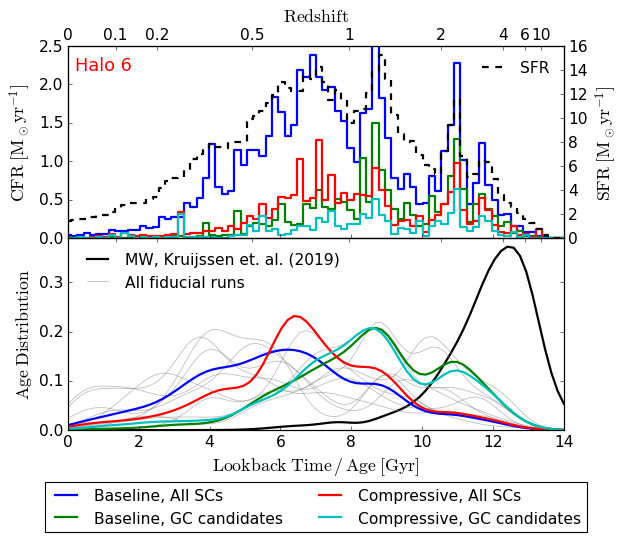

In [20]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].step(age_bins, cluster_formation_rate_all[0], where='mid', linewidth=2, label='Baseline, All SCs')
ax[0].step(age_bins, cluster_formation_rate_gc[0], where='mid', linewidth=2, label='Baseline, GC candidates')
ax[0].step(age_bins, cluster_formation_rate_all[1], where='mid', linewidth=2, label='Compressive, All SCs')
ax[0].step(age_bins, cluster_formation_rate_gc[1], where='mid', linewidth=2, label='Compressive, GC candidates')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
# ax[0].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[0].set_ylim(0,2.5)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].text(1, 2.25, 'Halo 6', fontsize=16, ha='center', va='center', c='r')
axr = ax[0].twinx()
axr.step(age_bins, sfr, where='mid', color='black', linestyle='--', linewidth=2, label='SFR')
axr.legend(frameon=False, fontsize=14)
axr.tick_params(axis='both', which='major', labelsize=14)
axr.set_ylabel(r'$\rm{SFR \; [M_\odot yr^{-1}]}$', fontsize=16)

ax[1].plot(age_bins, mw_age_dist/np.trapezoid(mw_age_dist, age_bins), linewidth=2, color='k', label='MW, Kruijssen et. al. (2019)')
for i, run in enumerate(fiducial_runs):
    if i==0:
        ax[1].plot(age_bins, run/np.trapezoid(run, age_bins), linewidth=0.75, color='grey', alpha=0.5, label='All fiducial runs')
    else:
        ax[1].plot(age_bins, run/np.trapezoid(run, age_bins), linewidth=0.75, color='grey', alpha=0.5)
    # loc = np.argmax(run/np.trapezoid(run, age_bins))
    # ax[1].text(age_bins[loc], (run/np.trapezoid(run, age_bins))[loc] + 0.01, simulation_list[i][:first_char_index(simulation_list[i], '_')], fontsize=8, ha='center', va='center')

ax[1].plot(age_bins, age_distribution_surviving_all[0]/np.trapezoid(age_distribution_surviving_all[0], age_bins), linewidth=2)
ax[1].plot(age_bins, age_distribution_surviving_gc[0]/np.trapezoid(age_distribution_surviving_gc[0], age_bins), linewidth=2)
ax[1].plot(age_bins, age_distribution_surviving_all[1]/np.trapezoid(age_distribution_surviving_all[1], age_bins), linewidth=2)
ax[1].plot(age_bins, age_distribution_surviving_gc[1]/np.trapezoid(age_distribution_surviving_gc[1], age_bins), linewidth=2)
# for merger in mergers_au06:
#     ax[0].axvline(merger, color='m', linestyle=':', linewidth=2)
#     ax[1].axvline(merger, color='m', linestyle=':', linewidth=2)

ax[1].set_ylim(0,0.39)
ax[1].set_ylabel(r'$\rm{Age \; Distribution}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Lookback \; Time \, / \, Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].yaxis.set_major_locator(ticker.FixedLocator([0.0, 0.1, 0.2, 0.3]))
ax[1].legend(loc='upper left', fontsize=14, frameon=False)
ax[0].legend(loc='center', fontsize=14, bbox_to_anchor=(0.5, -1.4), ncol=2)
plt.subplots_adjust(hspace=0.0)

# Compute redshift bins from age_bins using get_redshift and the first simulation
s = gadget_readsnap(snapshot, snappath=parent_dir+sims[0]+'/output/', hdf5=True, onlyHeader=True)
# redshift_bins = get_redshift(s, age_bins)

# Add top axis for redshift correspondence (log scale for ticks, linear for main axis)
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
# Specify desired redshift tick positions
# custom_redshift_ticks = np.array([0, 0.1, 0.2, 0.5, 1, 2, 10, np.max(redshift_bins)])
custom_redshift_ticks = np.array([0, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10])

# Convert redshift ticks to corresponding lookback time using cosmology
# For each z, compute a = 1/(1+z), then lookback time
a_ticks = 1/(1+custom_redshift_ticks)
lookback_ticks = s.cosmology_get_lookback_time_from_a(a_ticks, is_flat=True)

# Set top axis ticks at lookback times corresponding to desired redshifts
ax_top.set_xticks(lookback_ticks)
ax_top.set_xticklabels(['{:.2g}'.format(z) for z in custom_redshift_ticks])
ax_top.set_xlabel(r'$\rm{Redshift}$', fontsize=16)
ax_top.tick_params(axis='x', labelsize=14)

# Add top axis for redshift correspondence to the bottom subplot as well
ax_top2 = ax[1].twiny()
ax_top2.set_xlim(ax[1].get_xlim())
ax_top2.set_xticks(lookback_ticks)
ax_top2.set_xticklabels([])
plt.savefig('plots/age_distribution_and_cfr_paper.pdf', bbox_inches='tight')

In [14]:
merger_lists = []
for sim in simulation_list:
    mergers = get_merger_events_gyr_from_tree(parent_dir+sim, snapshot, minimum_ratio=1./20., verbose=False)
    merger_lists.append(mergers)

Identifying major merger events for simulation:  ./level4/Au06_cfea_fiducial
Loading merger tree at ./level4/Au06_cfea_fiducial/trees/
Infall time for this merger 9.314260827665183
TotalmassRatioAtInfall= 0.052241366
BaryonmassRatioAtInfall= 0.057488922
-----------------------------------
Infall time for this merger 11.136675920084876
TotalmassRatioAtInfall= 0.093607195
BaryonmassRatioAtInfall= 0.502096
-----------------------------------
Infall time for this merger 11.879430622983199
TotalmassRatioAtInfall= 0.053310927
BaryonmassRatioAtInfall= 0.20507255
-----------------------------------
Identifying major merger events for simulation:  ./level4/Au14_cfea_fiducial


/tmp/ipykernel_3458299/1203929130.py:115: RuntimeWarning: invalid value encountered in scalar divide
  BaryonmassRatioAtInfall = sat_baryon_mass / main_baryon_mass


Loading merger tree at ./level4/Au14_cfea_fiducial/trees/
Infall time for this merger 7.1187997068017825
TotalmassRatioAtInfall= 0.08267149
BaryonmassRatioAtInfall= 0.086942315
-----------------------------------
Infall time for this merger 8.087185677897974
TotalmassRatioAtInfall= 0.11196851
BaryonmassRatioAtInfall= 0.0883169
-----------------------------------
Infall time for this merger 8.999200926699
TotalmassRatioAtInfall= 0.099358164
BaryonmassRatioAtInfall= 0.08974601
-----------------------------------
Infall time for this merger 10.982127390835556
TotalmassRatioAtInfall= 0.11774276
BaryonmassRatioAtInfall= 0.25970605
-----------------------------------
Infall time for this merger 12.544099126317203
TotalmassRatioAtInfall= 0.08047317
BaryonmassRatioAtInfall= 0.17733844
-----------------------------------
Infall time for this merger 12.79028220915511
TotalmassRatioAtInfall= 0.0040109814
BaryonmassRatioAtInfall= 0.056661185
-----------------------------------
Infall time for this

In [15]:
mw_sfr = np.genfromtxt('catalogues_compare/mw_sfr.txt', delimiter=',', usecols=(0,1,3,5))

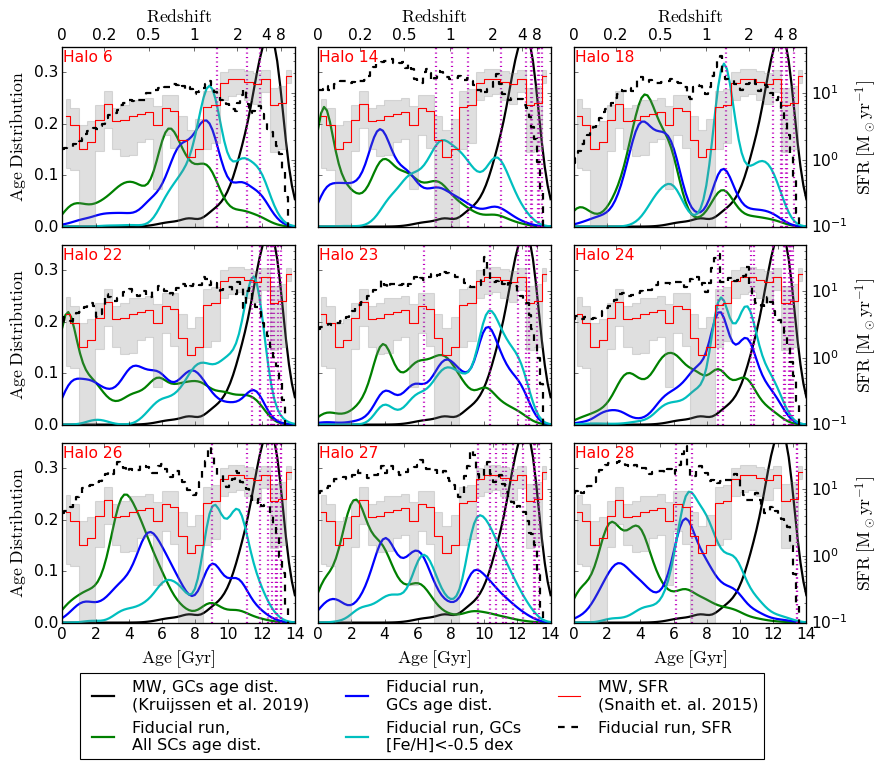

In [16]:
fig, ax = plt.subplots(3,3, sharey=True, figsize=(12,9))

# Compute redshift bins from age_bins using get_redshift and the first simulation
s = gadget_readsnap(snapshot, snappath=parent_dir+simulation_list[0]+'/output/', hdf5=True, onlyHeader=True)

# Specify desired redshift tick positions
# custom_redshift_ticks = np.array([0, 0.1, 0.2, 0.5, 1, 2, 10, np.max(redshift_bins)])
custom_redshift_ticks = np.array([0, 0.2, 0.5, 1, 2, 4, 8])

for i in range(3):
    for j in range(3):
        idx = i*3 + j 
        if idx < len(simulation_list):
            axr = ax[i,j].twinx()
            axr.step(mw_sfr[:,0], mw_sfr[:,1], where='mid', color='red', linewidth=1, label='MW, SFR'+'\n'+'(Snaith et. al. 2015)')
            axr.fill_between(mw_sfr[:,0], mw_sfr[:,2], mw_sfr[:,3], step='mid', color='grey', alpha=0.25)
            ax[i,j].plot(age_bins, mw_age_dist/np.trapezoid(mw_age_dist, age_bins), linewidth=2, color='k', label='MW, GCs age dist.'+'\n'+'(Kruijssen et al. 2019)')
            axr.step(age_bins, fiducial_sfr[idx], where='mid', color='black', linestyle='--', linewidth=2, label='Fiducial run, SFR')
            ax[i,j].plot(age_bins, fiducial_allsc[idx]/np.trapezoid(fiducial_allsc[idx], age_bins), linewidth=2, c='g', label='Fiducial run,'+'\n'+'All SCs age dist.')
            ax[i,j].plot(age_bins, fiducial_runs[idx]/np.trapezoid(fiducial_runs[idx], age_bins), linewidth=2, c='b', label='Fiducial run,'+'\n'+'GCs age dist.')
            ax[i,j].plot(age_bins, fiducial_wcut[idx]/np.trapezoid(fiducial_wcut[idx], age_bins), linewidth=2, c='c', label='Fiducial run, GCs'+'\n'+'[Fe/H]<-0.5 dex')
            ax[i,j].set_yticks([0.0, 0.1, 0.2, 0.3])
            axr.tick_params(axis='both', which='major', labelsize=14)
            for merger in merger_lists[idx]:
                ax[i,j].axvline(merger, color='m', linestyle=':', linewidth=2)#, label='Gas rich merger')
            # ax[i,j].text(0.05, 0.33, simulation_list[idx][:first_char_index(simulation_list[idx], '_')], fontsize=14, ha='left', va='center', color='r')
            ax[i,j].text(0.05, 0.33, 'Halo '+halo_list[idx], fontsize=14, ha='left', va='center', color='r')

        # Add top axis for redshift correspondence (log scale for ticks, linear for main axis)
        ax_top = ax[i,j].twiny()
        ax_top.set_xlim(ax[i,j].get_xlim())

        # Convert redshift ticks to corresponding lookback time using cosmology
        # For each z, compute a = 1/(1+z), then lookback time
        a_ticks = 1/(1+custom_redshift_ticks)
        lookback_ticks = s.cosmology_get_lookback_time_from_a(a_ticks, is_flat=True)

        # Set top axis ticks at lookback times corresponding to desired redshifts
        ax_top.set_xticks(lookback_ticks)

        if i==0:
            ax_top.set_xticklabels(['{:.2g}'.format(z) for z in custom_redshift_ticks])
            ax_top.set_xlabel(r'$\rm{Redshift}$', fontsize=16)
            ax_top.tick_params(axis='x', labelsize=14)
        else:
            ax_top.set_xticklabels([])

        if i==2:
            ax[i,j].set_xlim(0,14)
            ax[i,j].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
        # elif i==3 and j==2:
        #     ax[i,j].set_xlim(0,14)
        #     ax[i,j].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
        else:
            ax[i,j].set_xlim(0,14)
            ax[i,j].set_xticklabels([])
        
        if j==0:
            ax[i,j].set_ylabel(r'$\rm{Age \; Distribution}$', fontsize=16)
            ax[i,j].set_ylim(0,0.35)

        if j==2:
            axr.set_yscale('log')
            axr.set_ylim(1e-1, 5e1)
            axr.set_ylabel(r'$\rm{SFR \; [M_\odot yr^{-1}]}$', fontsize=16)
        # elif j==1 and i==4:
        #     axr.set_yscale('log')
        #     axr.set_ylim(1e-1, 5e1)
        #     axr.set_ylabel(r'$\rm{SFR \; [M_\odot yr^{-1}]}$', fontsize=16)
        else:
            axr.set_yscale('log')
            axr.set_ylim(1e-1, 5e1)
            axr.set_yticklabels([])

        ax[i,j].tick_params(axis='both', which='major', labelsize=14)

# Collect handles and labels from all axes (including twin axes) except the last one
handles = []
labels = []
for a in fig.axes:
    # if a is ax_last:
    #     continue
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Keep unique labels in order
seen = set()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l and l not in seen:
        seen.add(l)
        unique_handles.append(h)
        unique_labels.append(l)

fig.legend(unique_handles, unique_labels, loc='center', bbox_to_anchor=(0.5, -0.03), frameon=True, ncol=3)

# ax[4,2].remove()
# ax_top.remove()

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('plots/age_distribution_fiducial_runs_paper.pdf', bbox_inches='tight')